## Editing pyrare.py

Here, we deleted the fixed levels version, and we will concertrate on the performance of adaptive version of multilevel
splitting method. In the class **RareEvents**, we trace the complete ancestral tree by the matrix $\xi$ and A.

In [1407]:
import numpy as np
from time import time


class RareEvents:
    def __init__(self, mu_0, score_function,
                 shaker,level, p_0 = 0.75):
        """
        :param level: level to estimate
        :param p_0: successful rate, the classical way is to choose p_0 large,
                    but for AMS, in order to fix the level, we would like to choose
                    p_0 small. This will also improve the quality of the variance 
                    estimator.
        :param mu_0: distribution of X_0
        :param score_function: black box score_function
        :param shaker: metro-polis/Gibbs/Gaussian(for the toy example) kernel
        
        Remark:
        
        1. For the estimation of variance, we cannot change the times of
        shaking by the empirical reject_rate. The shaking procedure won't
        change the unbiasedness of the approximation of terminal path
        measures \gamma_n^N and \eta_n^N, but it will change the intergral
        operator \phi_p and the variance itself, and that's why the more we
        shake, the more close we get to the theoretical lower bound of the
        asymptotic variance. But, as we did before, if we really want a
        little variance which is close to the theoretical lower bound, this
        trick is still useful.

        2. The 1st estimator is the estimator of non asymptotic variance,
        which is relatively easier to get by the algorithm we provided. We
        have the a.s. convergence of this estimator to the asymptotic ones.
        
        3. We cannot use permutation to replace the multinomial procedure
        anymore. This trick will not effect the estimation of the
        \gamma_n and the crude estimator of the variance, but our
        estimator is not compatible with this trick. Further study will be
        done in a form of reconstruction of genealogical structure of the
        complete ancestral trees.  
        """
        self.mu_0 = mu_0
        self.score_function = score_function
        self.shaker = shaker
        self.level = level
        self.p_0 = p_0

    def adaptive_levels(self,N, shake_times = 1, status_tracking = False):
        ###### Initiation
        t_0 = time()
        xi = []
        X = self.mu_0(N)
        xi += [X]
        A = [] 
        
        p_0 = self.p_0
        L = np.array([-np.Inf,np.sort(self.score_function(X))[np.int((1-p_0)*N)]])
        k = 1
        E = []
        E += [range(N)]

        while(L[k]<self.level):
            I = []
            survive_index = []
            for i in range(N):
                if self.score_function(X[i])>L[k]:
                    I += [X[i]]
                    #S_called_times += 1
                    survive_index += [i]
            ell = len(I) 
           # to ensure that I_k would not be empty
            if ell == 0:        
                break

           # we remark that the permutation trick below doesn't work for the estimator of var

            #I = np.random.permutation(I)
            #q = 0
            #for i in clone_index:
            #    X[i] = I[q%ell]
            #    q += 1
            A_k = [] 
            X_cloned = np.zeros(N)
            for i in range(N):
                A_k += [int(np.random.choice(survive_index))]
                X_cloned[i] = X[A_k[i]]
            
            A += [A_k]   
            X = X_cloned

            
            for index_shaker in range(shake_times):
                for j in range(N):
                    X_iter = self.shaker(X[j])
                    X[j] = X_iter
            L = np.append(L, np.sort(self.score_function(X))[np.int((1-p_0)*N)])
            xi += [X]
            k += 1
            n = k

        N_L = np.sum((self.score_function(X)>self.level))
        r_hat = N_L/float(N)
        p_hat = p_0**(n-1)*r_hat 

        if status_tracking ==True:
            print ("estimation of p: " + str(p_hat))
            print ('____________________________________________________________\n')
            print ("Time spent: %s s" %(time() - t_0) )
            #print ("score_function called: %s times" % S_called_times)
        output = {'p_hat':p_hat,  \
                  'A':A,\
                  'xi':xi,\
                 }    
        return output 


## Test by the toy example

In [1408]:
import sys
from scipy.stats import norm
from time import time
from ProgressBar import *
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [1413]:
def S_test(X):
    #score function which is a black box
    #return np.abs(X)
    return X

def get_paramS_test(level_test = 8, p_0 = 0.75,status_tracking = True):

    real_p = 1-norm.cdf(level_test)

    ###idealized situation

    n_0 = int(np.floor(np.log(real_p)/np.log(p_0)))
    r = real_p/(p_0**n_0)
    sigma_theoretical = np.sqrt(n_0*(1-p_0)/p_0 + (1-r)/r)
    l = [-np.inf]
    for k in range(1,n_0+1,1):
        l = np.append(l, norm.ppf(1 - p_0**k/2))
    l_ideal = np.append(l, level_test)

    if status_tracking == True:
        print ("p_0 = " + str(p_0) + '\t n_0 =' + str(n_0) + "\t r = " + str(r))
        #print ("sequence of levels: "+ str(l_ideal))
        print ("real value of p: " + str(real_p))
        print ("relative deviation(ideal): " + str(sigma_theoretical))
    return real_p, sigma_theoretical, n_0, l_ideal

def mu_0_test(n):
    '''
    param n: the size of particles
    '''
    return np.random.normal(0,1,n)



#tuning parameter sigma_1 for shaker


def shaker_gaussian(x,sigma_1=0.1):
    c = np.sqrt(1+sigma_1**2)
    return np.random.normal(x/c,sigma_1/c,1)

def shaker_metropolis(x,sigma_1):
    iter = np.random.uniform(x-sigma_1,x+sigma_1)
    if np.exp(-0.5*(iter**2-x**2))>np.random.rand(1):
   	return iter
    else:
    	return x


print ('\n============================================================')
####### parameters ######
p_0_test = 0.1 
N_test = 200
#shaker = shaker_metropolis
shaker = shaker_gaussian
shake_times = 10 
num_simulation = 200
level_test = 3
#def input_parameters():
#    print ('please input the parameters:\n')
#    p_0_test = input('p_0_test: ')
#    N_test = input('number of particles: ')
#    shake_times = input('shake_times: ')
#    shaker_choice = 'empty'
#    while shaker_choice not in ['metropolis', 'gaussian']:
#        shaker_choice = raw_input("shaker('metropolis' or 'gaussian'): ")
#    
#    if shaker_choice == 'metropolis':
#        shaker = shaker_metropolis
#    elif shaker_choice == 'gaussian':
#        shaker = shaker_gaussian
#    num_simulation = 100
#    return p_0_test, N_test, shaker, shake_times, num_simulation
#
#p_0_test, N_test, shaker, shake_times, num_simulation = input_parameters()
#########################

test_info = '|num_particles_' + str(N_test) + '|' + \
        str(shaker).split(' ')[1] + '|shake_times_' + str(shake_times) 
        

print ('Info: ' + test_info)
params = get_paramS_test(level_test = level_test, p_0 = p_0_test,status_tracking = True)

rare_test = RareEvents(mu_0 = mu_0_test, score_function = S_test,\
	level = level_test,shaker = shaker, p_0 = p_0_test)

#test
test_result = rare_test.adaptive_levels(N = N_test, shake_times = shake_times, status_tracking=True)
A = test_result['A']
xi = test_result['xi']


Info: |num_particles_200|shaker_gaussian|shake_times_10
p_0 = 0.1	 n_0 =2	 r = 0.134989803163
real value of p: 0.00134989803163
relative deviation(ideal): 4.9404419789
estimation of p: 0.00235
____________________________________________________________

Time spent: 0.0362191200256 s


(3, 200)


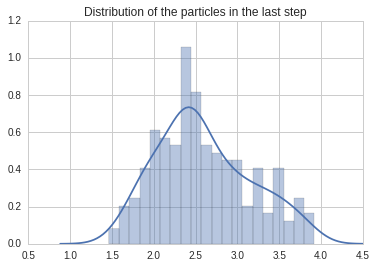

In [1414]:
print (np.shape(xi))
sns.distplot(xi[-1],bins = 20)
plt.title('Distribution of the particles in the last step')

(2, 200)


(array([  7.,   0.,   0.,   0.,   0.,   8.,   0.,   0.,   5.,   8.,   0.,
          0.,  11.,  14.,  13.,   9.,   0.,   0.,   0.,   0.,   6.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  11.,   0.,   0.,   0.,
          0.,   0.,  10.,  12.,  15.,   9.,   0.,  11.,   0.,   0.,   0.,
          0.,   8.,   0.,   9.,  15.,  19.]),
 array([  13.  ,   16.66,   20.32,   23.98,   27.64,   31.3 ,   34.96,
          38.62,   42.28,   45.94,   49.6 ,   53.26,   56.92,   60.58,
          64.24,   67.9 ,   71.56,   75.22,   78.88,   82.54,   86.2 ,
          89.86,   93.52,   97.18,  100.84,  104.5 ,  108.16,  111.82,
         115.48,  119.14,  122.8 ,  126.46,  130.12,  133.78,  137.44,
         141.1 ,  144.76,  148.42,  152.08,  155.74,  159.4 ,  163.06,
         166.72,  170.38,  174.04,  177.7 ,  181.36,  185.02,  188.68,
         192.34,  196.  ]),
 <a list of 50 Patch objects>)

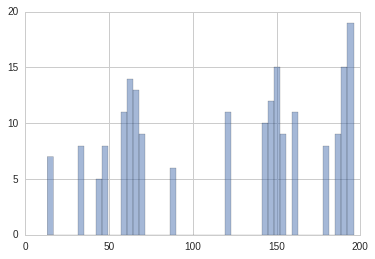

In [1415]:
print (np.shape(A))
plt.hist(A[-1],alpha = 0.5,bins = 50)

## matrix O
O[p][q][i]: the ancester in the time p of the i st particle in the time q. 

In [1416]:
n = np.shape(xi)[0]-1 
N = N_test

In [1417]:
O = np.zeros((n+1,n+1,N))
np.shape(O)

(3, 3, 200)

In [1418]:
for p in range(n+1):
    for q in np.arange(p,n+1):
        for i in range(N):
            k = q
            anc = i
            while k>p:
                anc = A[k-1][anc]
                k -= 1
            O[p][q][i] = anc 
    

In [1419]:
print (O[n-2][n][29])
print (A[n-2][A[n-1][29]])


179.0
179


In [1420]:
I_n = []
for i in range(N):
    if xi[n][i]> level_test:
        I_n += [i]
len(I_n)

47

In [1421]:
V = 0
ell_I_n = len(I_n)
for p in np.arange(1,n+1):
    for i in range(ell_I_n):
        for j in np.arange(i+1,ell_I_n):
            for z in range(N):
                idx = (O[p][n][I_n[i]] != O[p][n][I_n[j]])
                idx *= (O[p-1][n][I_n[i]] == O[p-1][n][I_n[j]])
                idx *= (O[0][n][I_n[i]] != O[0][p-1][z])
                if idx == 1:
                    V+=2
                            
V *= N**(n-1)*1.0/(N-1)**(n+1) 
V       

9.966958095444268

In [1422]:
nb_c = np.zeros((n,N))
for p in np.arange(1,n+1):
    for k in range(N):
        for i in I_n: 
            if O[p-1][n][i] == k:
                nb_c[p-1][k] += 1
                

In [1426]:
nb_c[1]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         4.,   0.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   